#ANÀLISI DEL ADS1 i ADS2 DEL SINTETITZADOR RSF KOBOL EXPANDER

En aquest document de Python es fa l'estudi de la relació entre l'envolvent ADS 1 i 2.


In [2]:
# Importem llibreries
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import soundfile as sf
import librosa
import pandas as pd

# Importem pydub per poder reproduir audio amb un simbol rate de 96.000Hz
!pip install pydub
from pydub import AudioSegment
from pydub.playback import play

Importem Drive i ruta dels enregistraments. Per compilar el programa cal cal canviar la variable files_path


In [3]:
# Importem Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Carregar arxius .wav a través de la següent direcció
files_path = '/content/drive/Shareddrives/TFG_Virtualització_RSF_Kobol_Expander/Laboratori/ENREGISTRAMENTS ADS1 vs ADS2'

# UTILS

Definim funcions que seran utils i essencials durant l'anàlisi.


In [5]:
#Funció per llegir audios i obtenir un array i simbol rate

def read_file(path):
  all_path = str(files_path + "/" + path)
  audio, frame_rate = sf.read(all_path)
  return audio, frame_rate


# Funció per tallar les msotres i obtindre mostres sense el silenci inicial i final
def audio_cutter(audio):

  # Definim un llindar i normalitzem el àudio
  silence_threshold = 0.025
  audio_normalized = abs(audio) / np.max(audio)

  start = 0
  #Trobem la primera mostra després de passar el umbral
  for i in range(len(audio)):
    if audio_normalized[i] > silence_threshold:
      start = i
      break

  end = len(audio)
  #Trobem la última mostra per sobre el umbral
  for i in range(len(audio) -1, -1, -1):
    if audio_normalized[i] > silence_threshold :
      end = i
      break

  audio_cut = audio[start:end]
  return audio_cut


# Funció que retorna el primer segon de sustain
# Permet tenir una mostra amb amplitud constant en tota la mostra
def stereo_audio_cutter(audio):

  silence_threshold = 0.02
  audio_normalized = abs(audio) / np.max(audio) #Normalització a ADS1 i ADS2

  length = len(audio[:,0])
  end = length

  #Trobem la primera mostra després de passar el umbral de ADS 1 i 2
  for i in range(length):
    if audio_normalized[i,0] > silence_threshold or audio_normalized[i,1] > silence_threshold:
      start = i
      break

  end1 = 0
  end2 = 0
  #Trobem la última mostra per sobre el umbral
  for i in range(length -1, -1, -1):
    if audio_normalized[i,0] > silence_threshold:
      end1 = i
      break

  for i in range(length -1, -1, -1):
    if audio_normalized[i,1] > silence_threshold:
      end2 = i
      break

  end = max(end1, end2)
  cutted_audio = np.zeros((end-start,2))
  cutted_audio = audio[start:end,:]

  # Zero padding
  if(start - end1 > start - end2):

    cutted_audio[end2:,1] = 0.001
  else:
    cutted_audio[end1:,0] = 0.001

  return cutted_audio



# Funció per visualitzar mostres
def visualize(audio,sr, title1 = " ", title2 = " "):

  time = np.linspace(0,np.shape(audio)[0]/sr, num = np.shape(audio)[0])  #time axis
  channels = np.shape(audio)[1]
  if channels == 2:

    #Plot canal esquerre (L)
    plt.figure(figsize=(14, 2))
    plt.xlabel("seconds")
    plt.ylabel('Amplitude')
    plt.title(title1, fontname='serif')
    plt.plot(time, audio[:,0])

    plt.show()

    #Plot canal dret (R)
    plt.figure(figsize=(14, 2))
    plt.xlabel("seconds")
    plt.ylabel('Amplitude')
    plt.title(title2, fontname='serif')
    plt.plot(time, audio[:,1])
    plt.show()

  else:

     #Plot canal sol
    plt.figure(figsize=(14, 2))
    plt.xlabel("seconds")
    plt.ylabel('Amplitude')

    plt.title(title)
    plt.plot(time, audio)

    plt.show()

def exponential_func(x, a, b):
    return a * np.exp(b * x)

# ENREGISTRAMENTS
Comencem important tots els enregistraments i ordenant-los. S'ordenen altabèticament en arrays per després accedir-hi facilment.


In [6]:
wav_list = os.listdir(files_path) #Llista de direccions dels arxius
print('Hi ha un total de ', len(wav_list), ' mostres.')

attack_list = []
decay_list = []
sustain_list =[]
ads1_sound = []
ads1_full = []


for file in wav_list:

  if "Attack" in file:
    attack_list.append(file)

  elif "Decay" in file:
    decay_list.append(file)

  elif "Sustain" in file:
    sustain_list.append(file)

  elif "sound" in file:
    ads1_sound.append(file)
  elif "full" in file:
    ads1_full.append(file)


# Ordenem cada lista individualment
attack_list.sort()
decay_list.sort()
sustain_list.sort()
ads1_sound.sort()
ads1_full.sort()



# Print del número de mostres
print("\nHi ha ", len(attack_list), " arxius de Attack.")
print("\nHi ha ", len(decay_list), " arxius de Decay.")
print("\nHi ha ", len(sustain_list), " arxius de Sustain.")
print("\nHi ha ", len(ads1_sound), " arxius de ads1 - sound.")
print("\nHi ha ", len(ads1_full), " arxius de ads1 complets.")




Hi ha un total de  41  mostres.

Hi ha  10  arxius de Attack.

Hi ha  10  arxius de Decay.

Hi ha  10  arxius de Sustain.

Hi ha  5  arxius de ads1 - sound.

Hi ha  6  arxius de ads1 complets.


# ANÀLISI DE MOSTRES
El següent codi permet visualitzar mostres


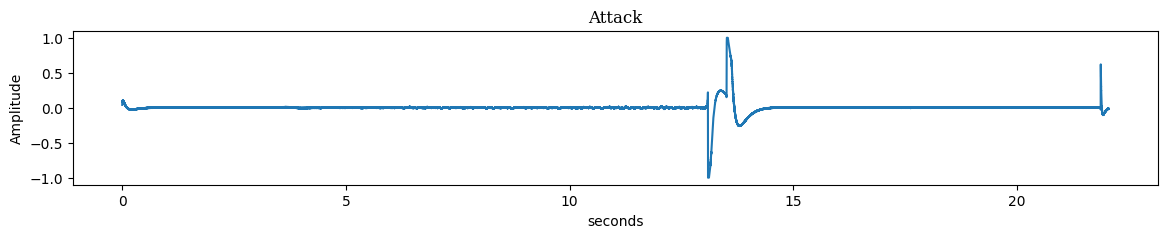

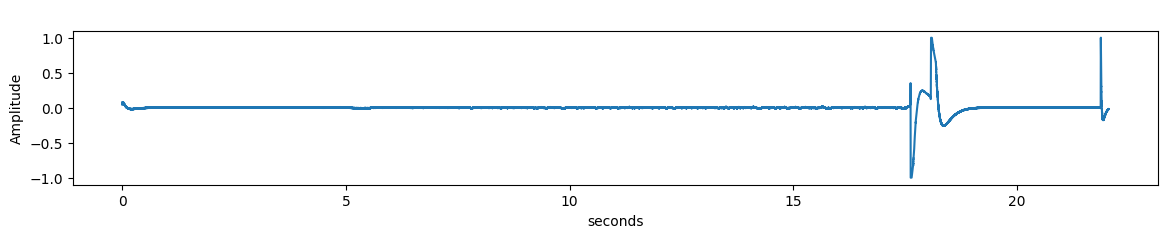

In [7]:
# Carregar la mostra que es vulgui visualitzar
file = attack_list[9]
audio, sr = read_file(file)

audio = stereo_audio_cutter(audio)

visualize(audio, sr, 'Attack')

# ATTACK: ADS1 vs. ADS2
En aquesta part es fa l'estudi de la relació de l'attack entre el ADS1 i el ADS2.

Les gràfiques mostren la sortida individual ADS OUT de cada envolvent des del moment en que es toca una tecla fins que es deixa d'apretar. Quan es toca s'activa el GATEE i s'observa el petit cop que fa a l'inici del senyal. Després el ADS OUT envia aquest senyal que queda al centre indicant que el Attack s'ha acabat. Finalment, es pot observar el impuls que deixa anar el ADS OUT quan s'aixeca la tecla.

Output Attack ADS1 vs ADS2 amb 1 Volts:


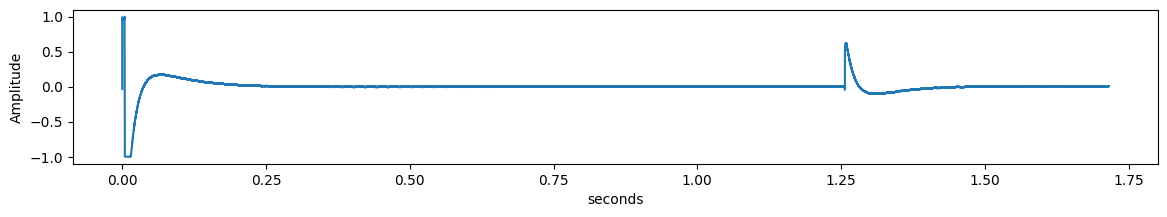

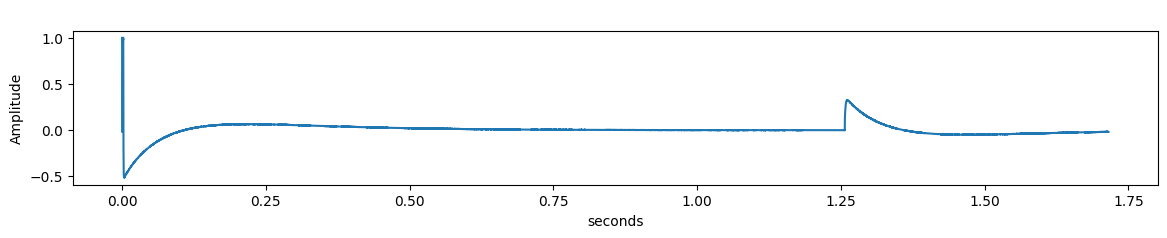

Output Attack ADS1 vs ADS2 amb 2 Volts:


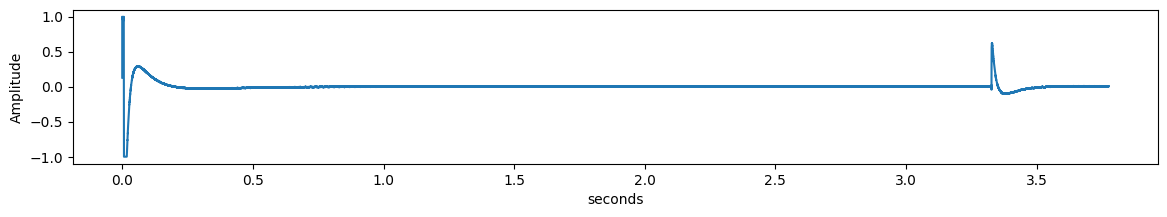

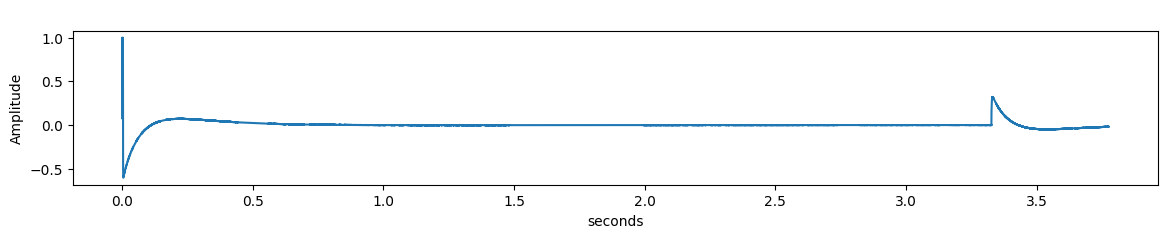

Output Attack ADS1 vs ADS2 amb 3 Volts:


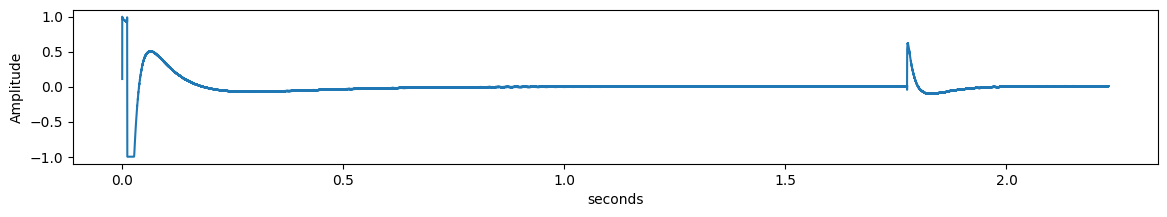

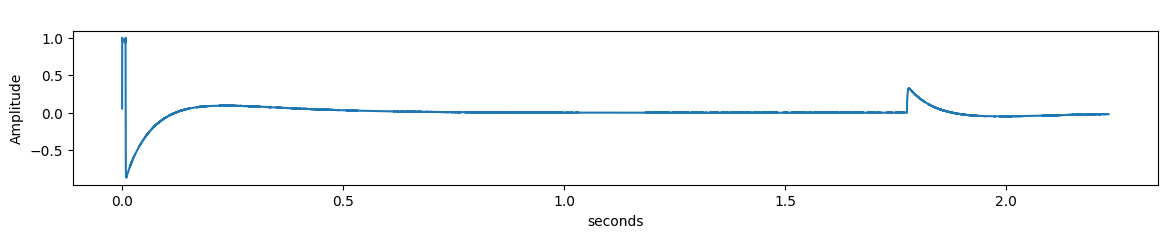

Output Attack ADS1 vs ADS2 amb 4 Volts:


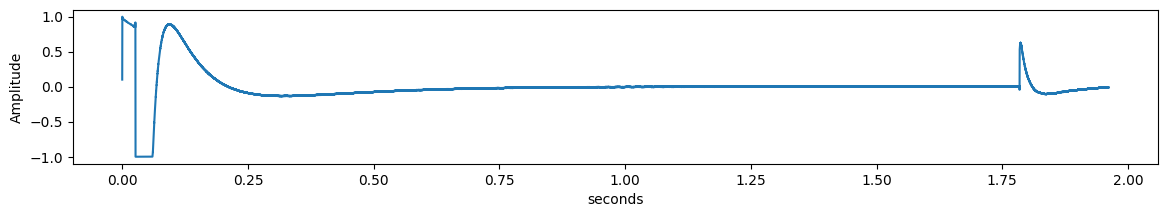

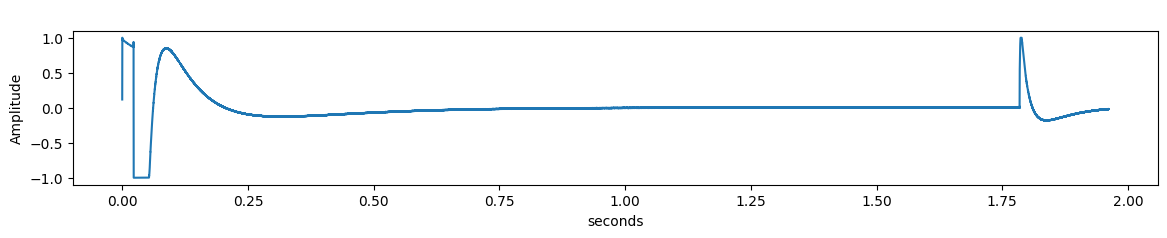

Output Attack ADS1 vs ADS2 amb 5 Volts:


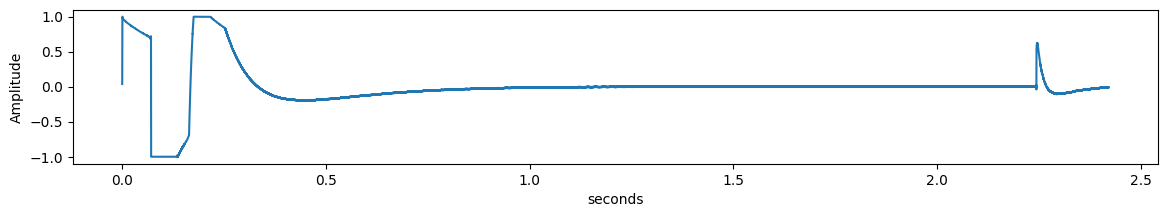

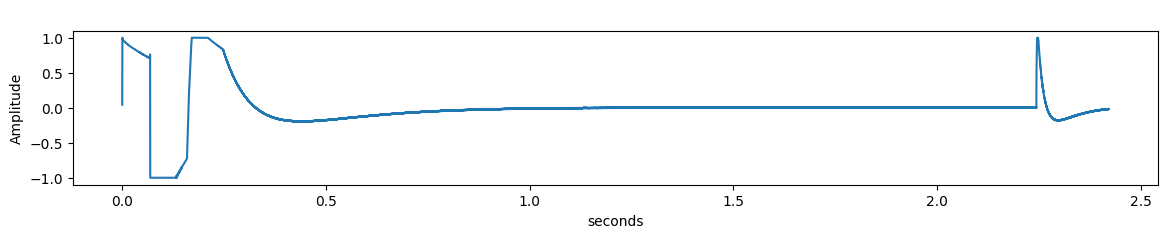

Output Attack ADS1 vs ADS2 amb 6 Volts:


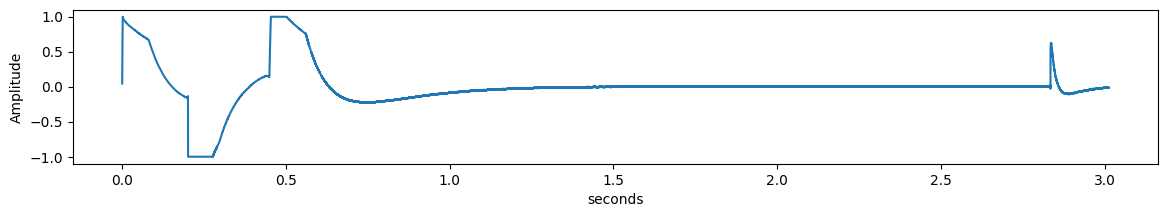

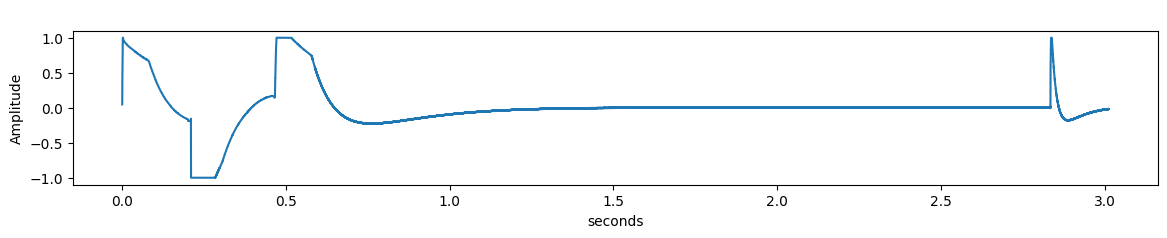

Output Attack ADS1 vs ADS2 amb 7 Volts:


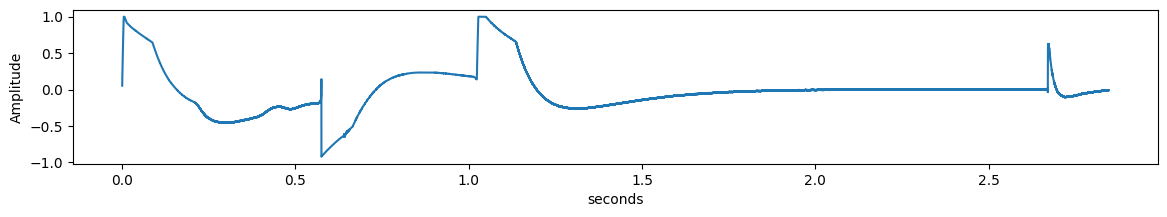

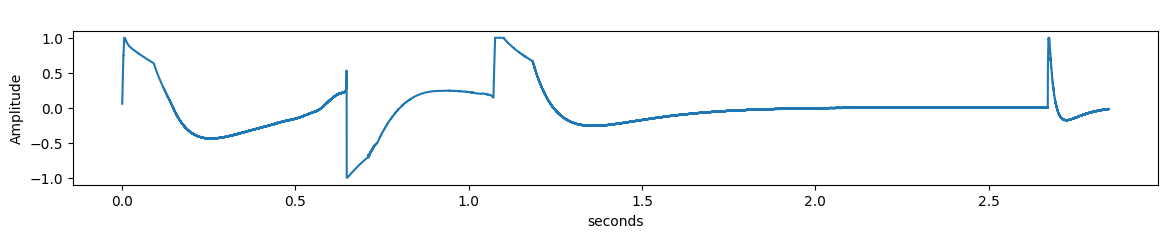

Output Attack ADS1 vs ADS2 amb 8 Volts:


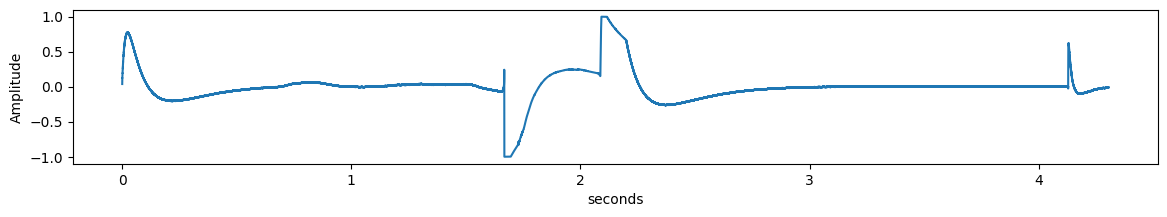

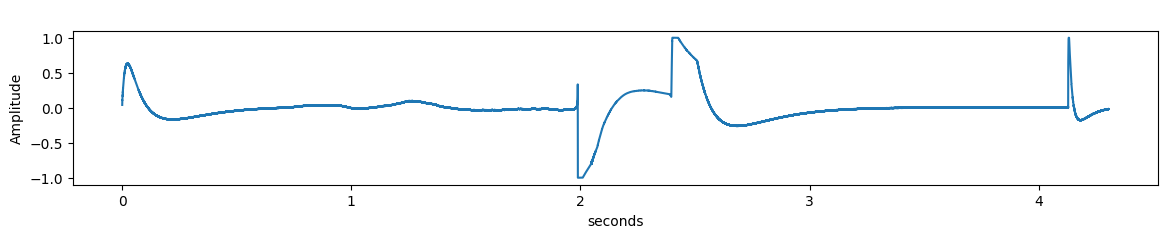

Output Attack ADS1 vs ADS2 amb 9 Volts:


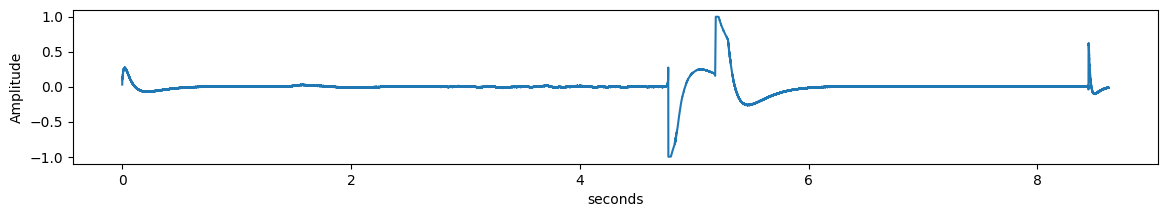

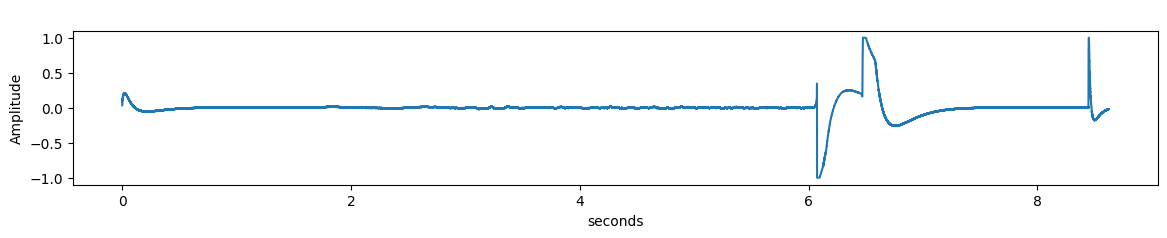

Output Attack ADS1 vs ADS2 amb 10 Volts:


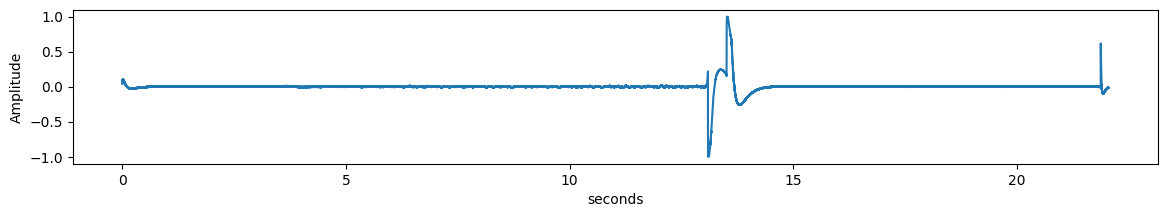

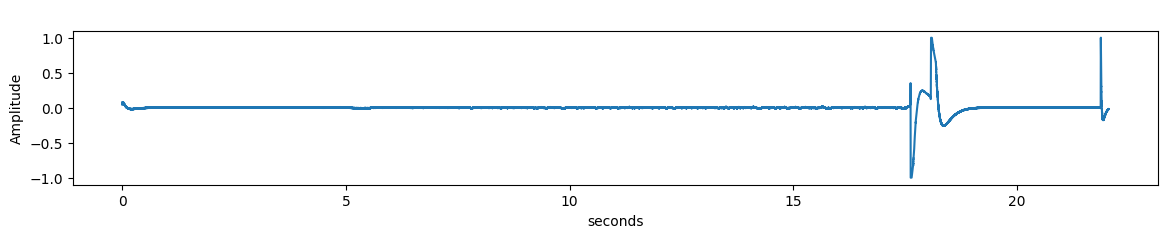

In [8]:
for i in range(len(attack_list)):
  print('Output Attack ADS1 vs ADS2 amb', i+1, 'Volts:')
  file = attack_list[i]
  audio, sr = read_file(file)
  audio = stereo_audio_cutter(audio)
  visualize(audio, sr, '')

# DECAY: ADS1 vs. ADS2
En aquesta part es fa l'estudi de la relació del Dttack entre el ADS1 i el ADS2.

Les gràfiques mostren la sortida individual ADS OUT de cada envolvent des del moment en que es toca una tecla fins que es deixa d'apretar. Quan es toca s'activa el GATEE i s'observa el petit cop que fa a l'inici del senyal. Després el ADS OUT envia aquest senyal que queda al centre indicant que el Decay s'ha acabat i comença el sustain. Finalment, es pot observar el impuls que deixa anar el ADS OUT quan s'aixeca la tecla.

És important remarcar que aquestes mostres s'han fet amb un Attack de zero. Sinó, tindriem una segona ona com la del centre abans de la ona que indica que el Decay s'ha acabat

Output Decay ADS1 vs ADS2 amb 1 Volts:


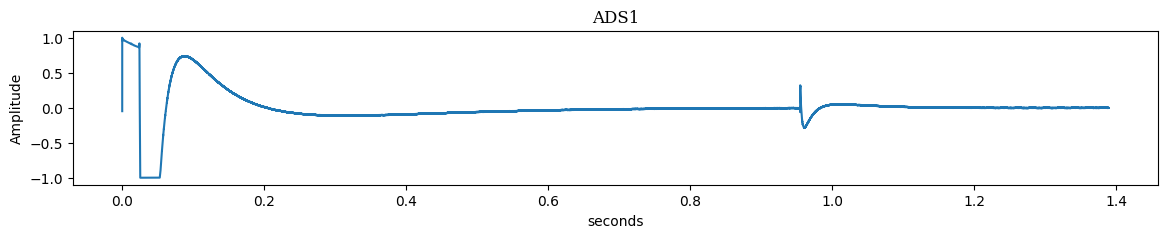

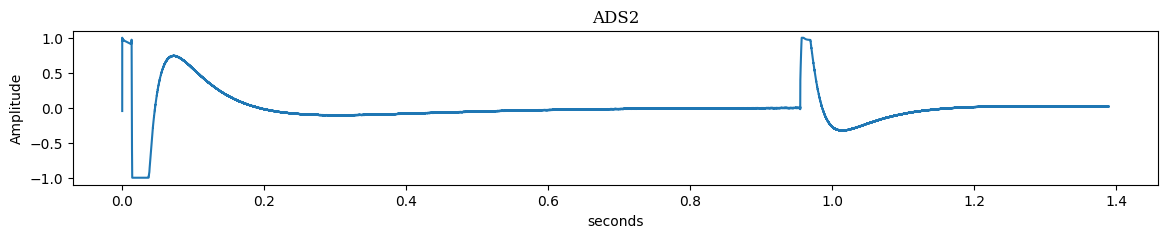

Output Decay ADS1 vs ADS2 amb 2 Volts:


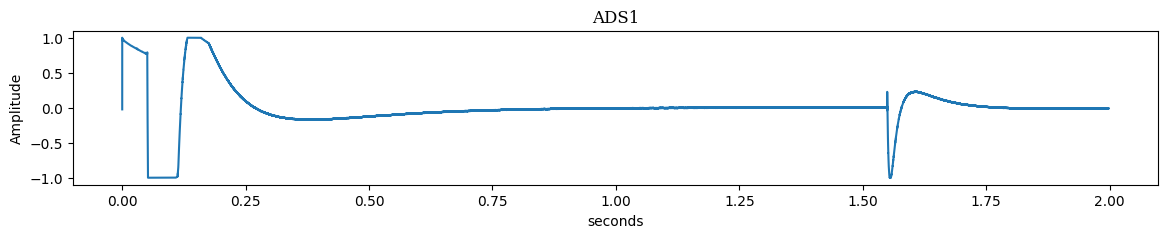

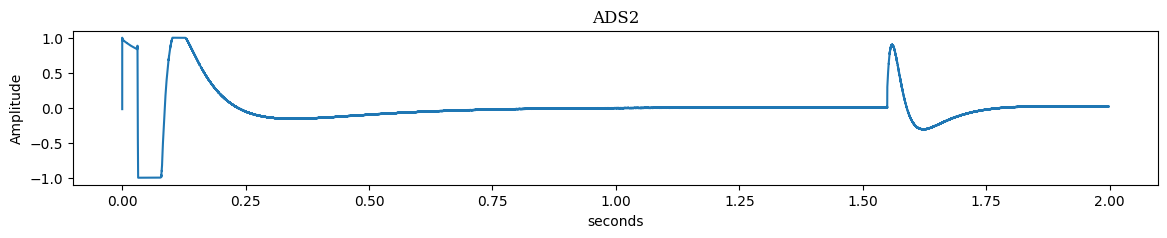

Output Decay ADS1 vs ADS2 amb 3 Volts:


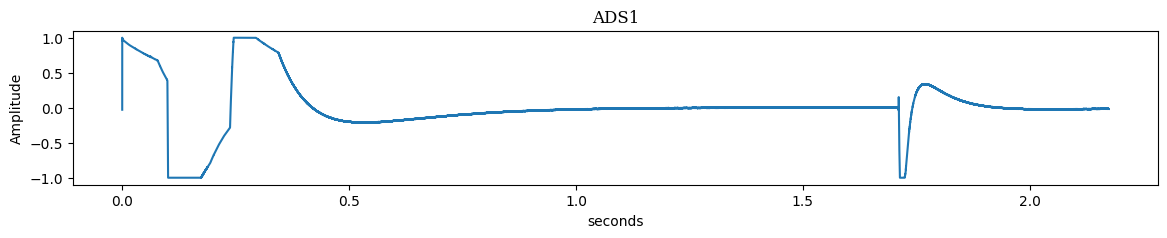

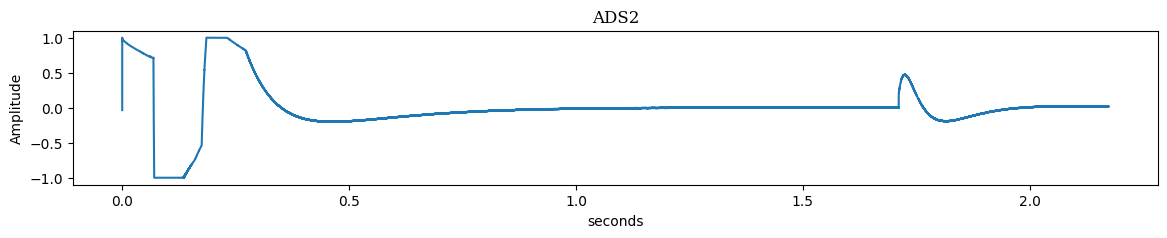

Output Decay ADS1 vs ADS2 amb 4 Volts:


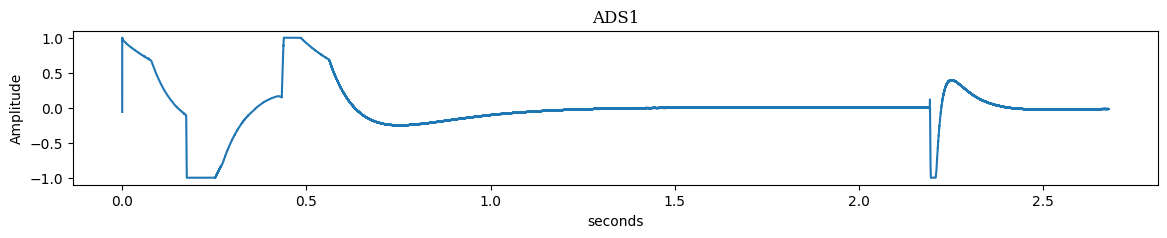

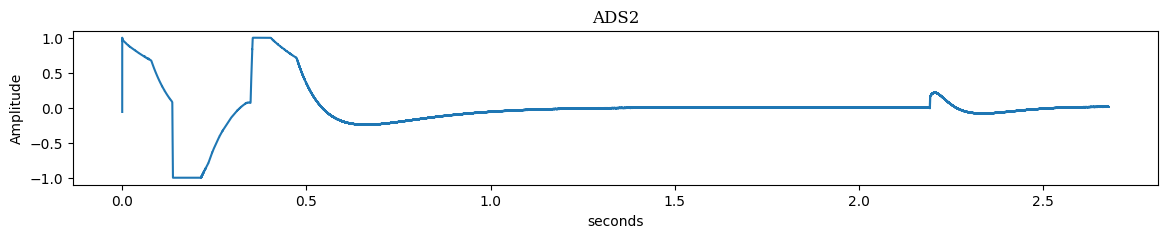

Output Decay ADS1 vs ADS2 amb 5 Volts:


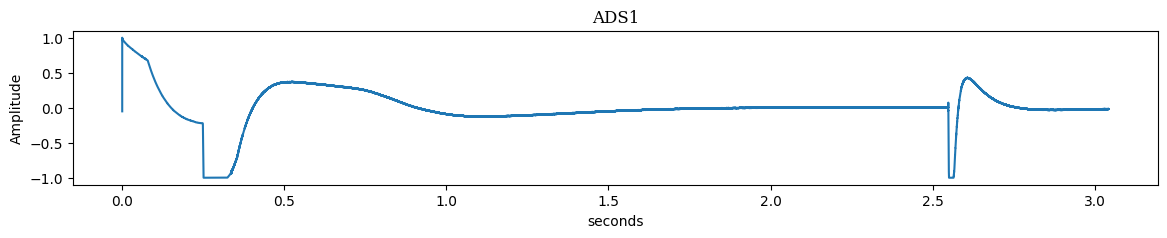

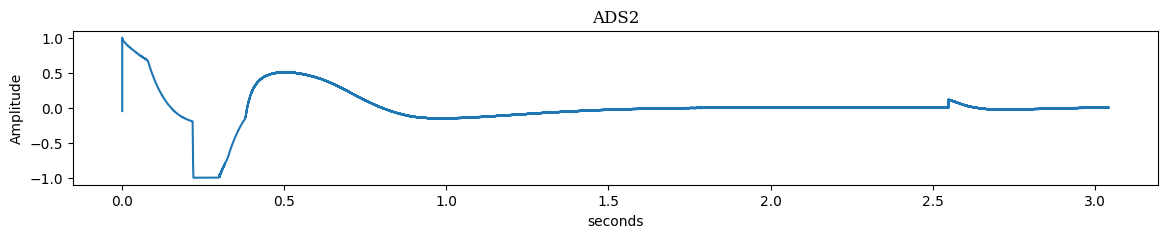

Output Decay ADS1 vs ADS2 amb 6 Volts:


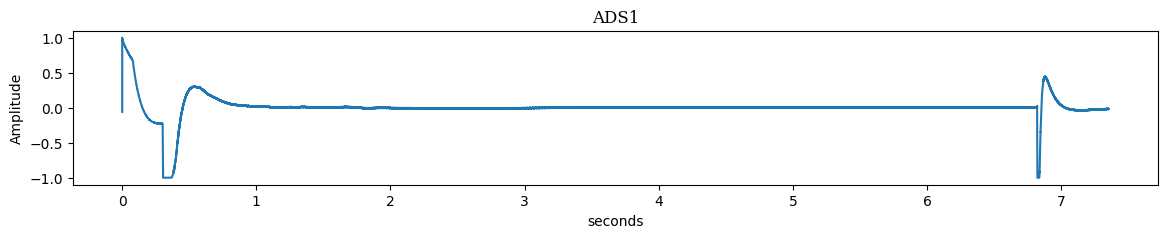

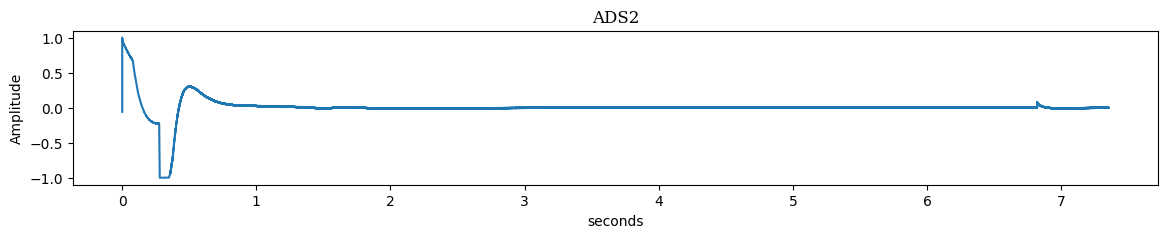

Output Decay ADS1 vs ADS2 amb 7 Volts:


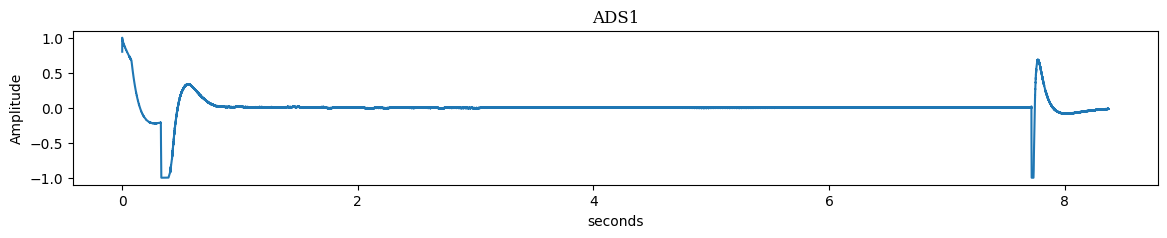

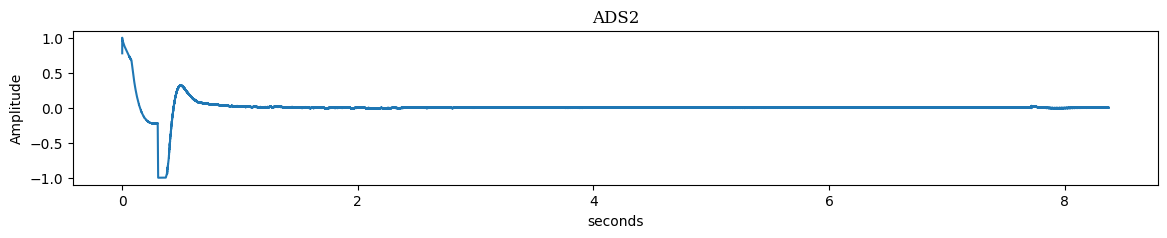

Output Decay ADS1 vs ADS2 amb 8 Volts:


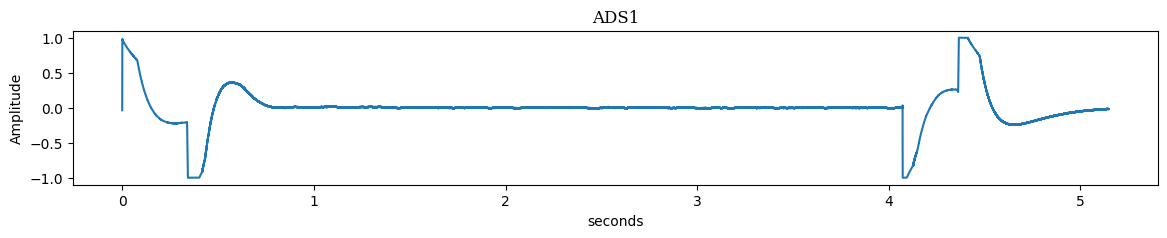

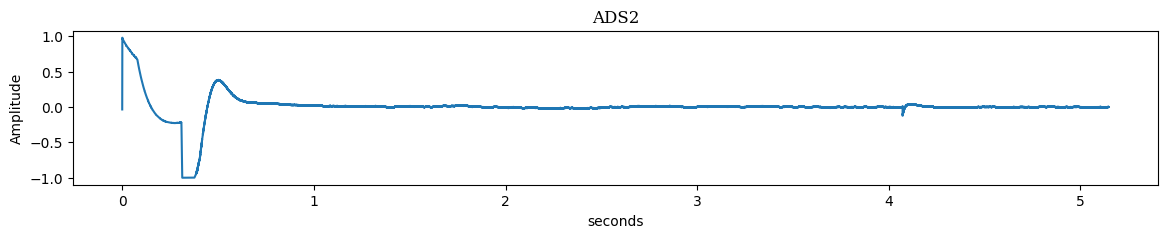

Output Decay ADS1 vs ADS2 amb 9 Volts:


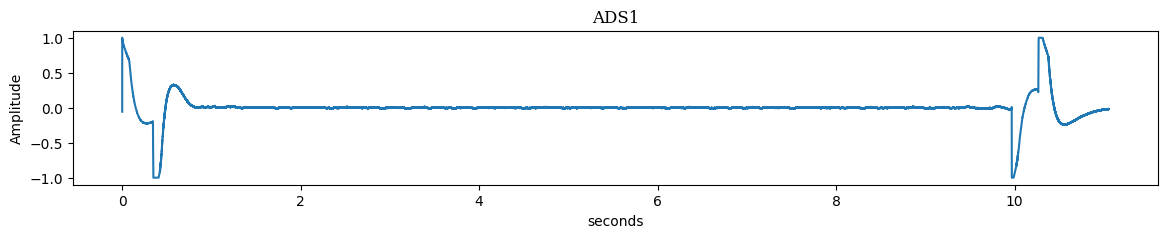

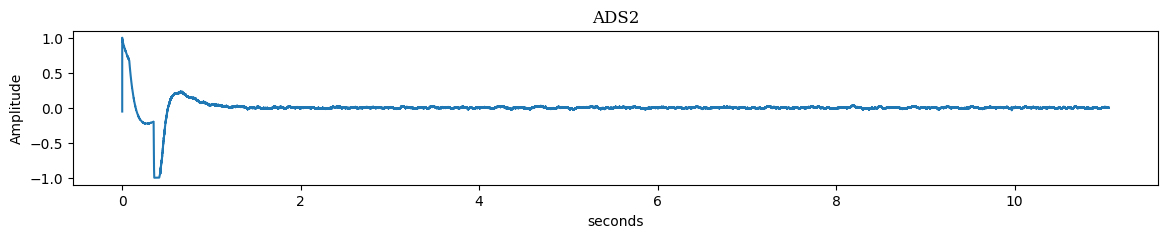

Output Decay ADS1 vs ADS2 amb 10 Volts:


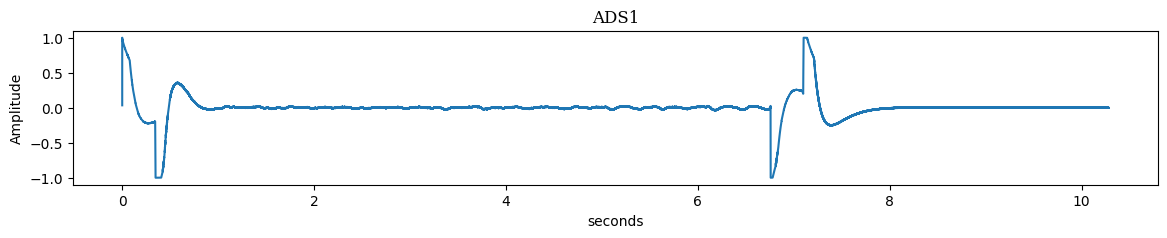

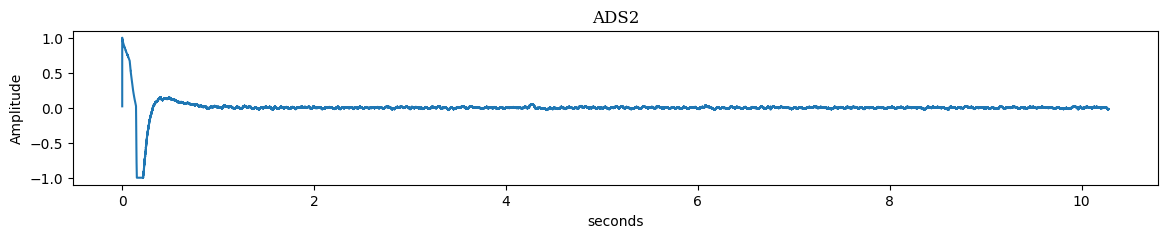

In [9]:
for i in range(len(decay_list)):
  print('Output Decay ADS1 vs ADS2 amb', i+1, 'Volts:')
  file = decay_list[i]
  audio, sr = read_file(file)
  audio = stereo_audio_cutter(audio)
  visualize(audio, sr, title1 = 'ADS1', title2 = 'ADS2')

# SUSTAIN: ADS1 vs. ADS2
En aquesta part es fa l'estudi de la relació de l'attack entre el ADS1 i el ADS2.

Les gràfiques mostren la sortida individual ADS OUT de cada envolvent des del moment en que es toca una tecla fins que es deixa d'apretar. Quan es toca s'activa el GATEE i s'observa el petit cop que fa a l'inici del senyal. Després el ADS OUT envia aquest senyal que queda al centre indicant que el Attack s'ha acabat. Finalment, es pot observar el impuls que deixa anar el ADS OUT quan s'aixeca la tecla.

Output Sustain ADS1 vs ADS2 amb 1 Volts:


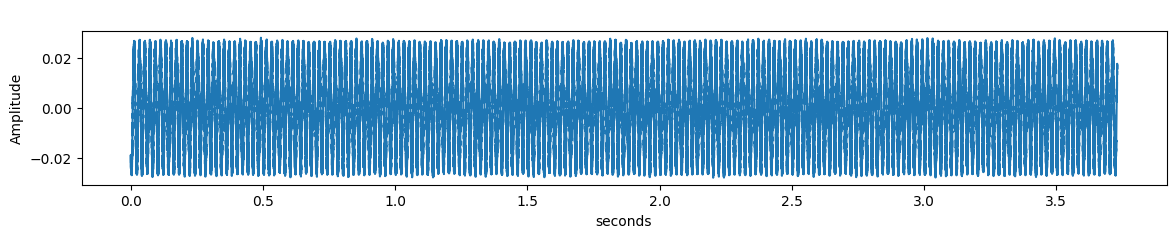

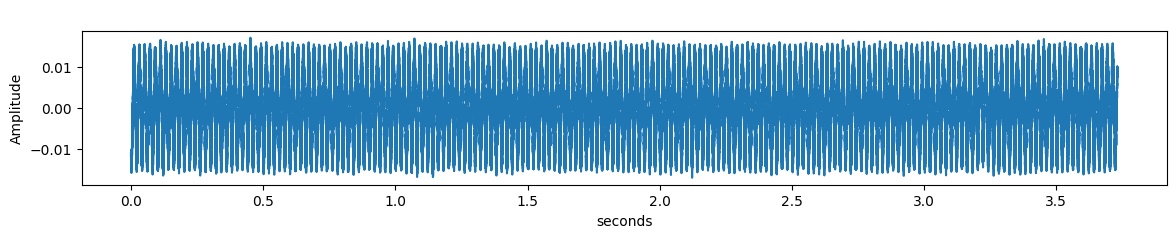

Output Sustain ADS1 vs ADS2 amb 2 Volts:


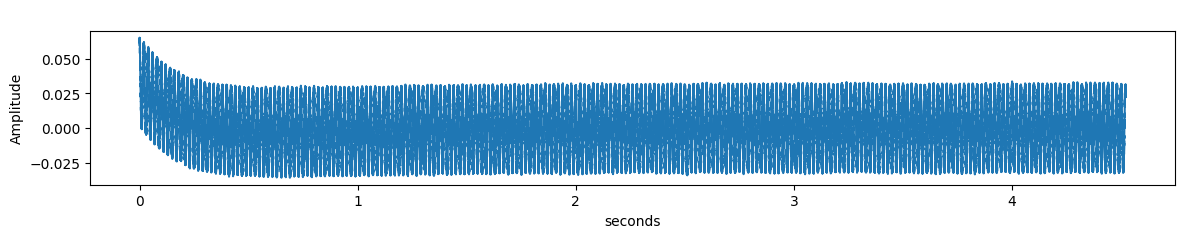

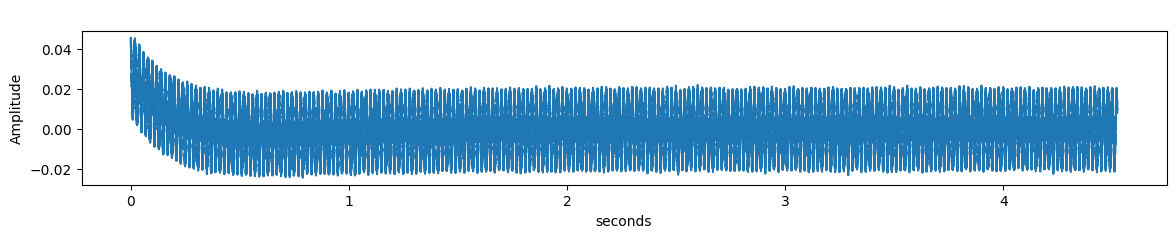

Output Sustain ADS1 vs ADS2 amb 3 Volts:


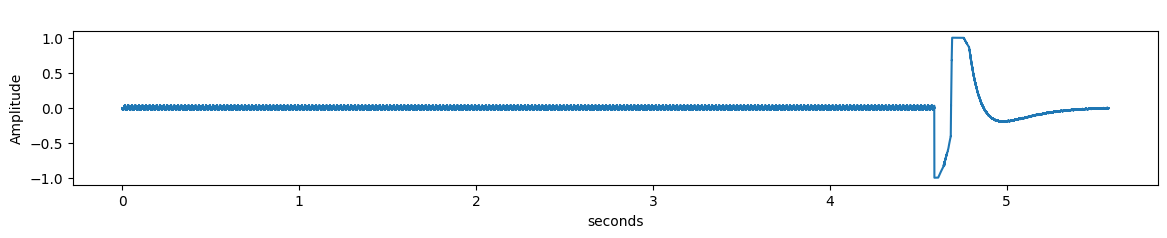

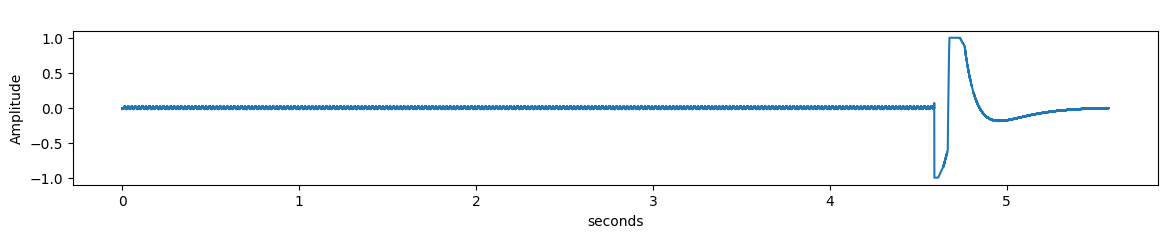

Output Sustain ADS1 vs ADS2 amb 4 Volts:


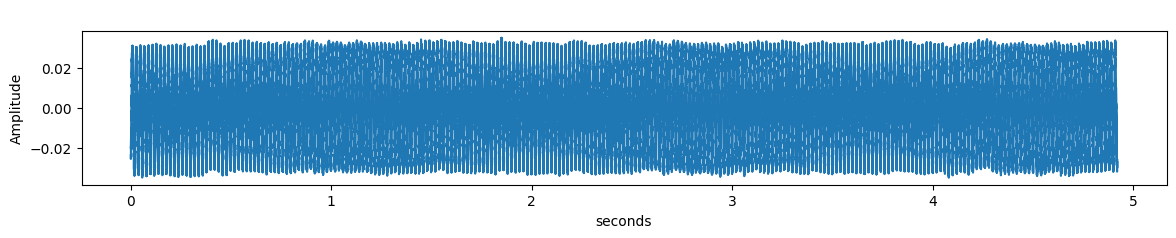

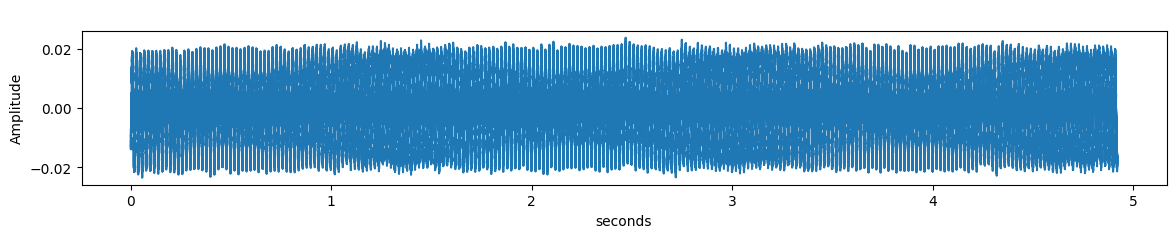

Output Sustain ADS1 vs ADS2 amb 5 Volts:


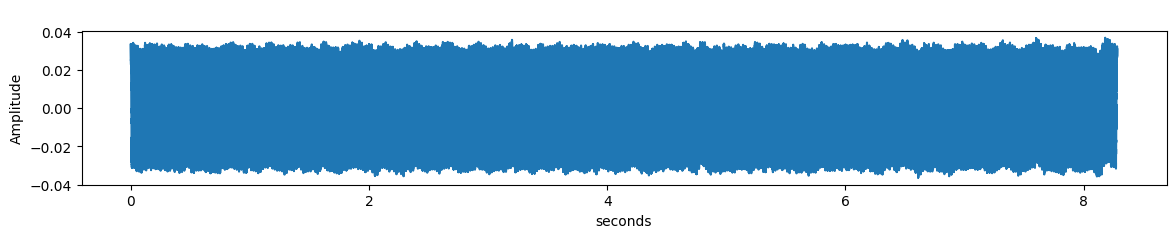

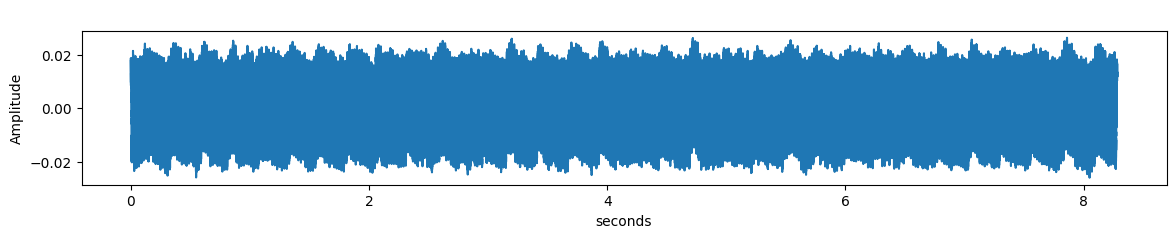

Output Sustain ADS1 vs ADS2 amb 6 Volts:


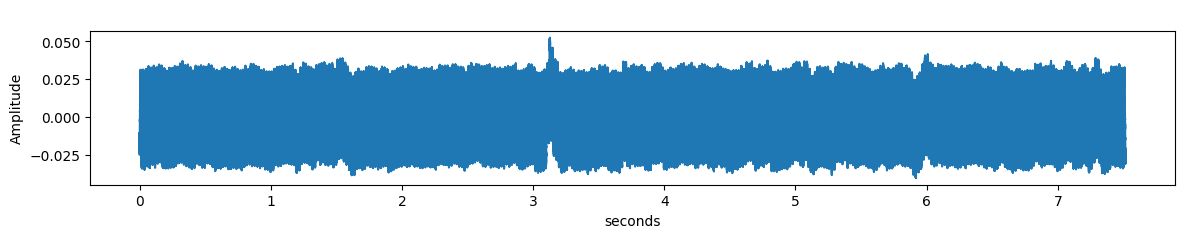

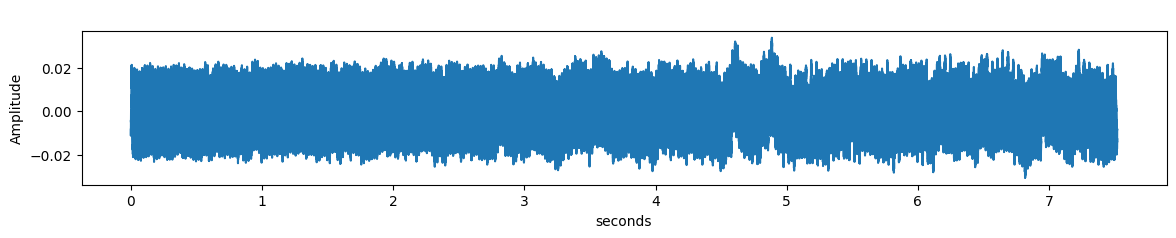

Output Sustain ADS1 vs ADS2 amb 7 Volts:


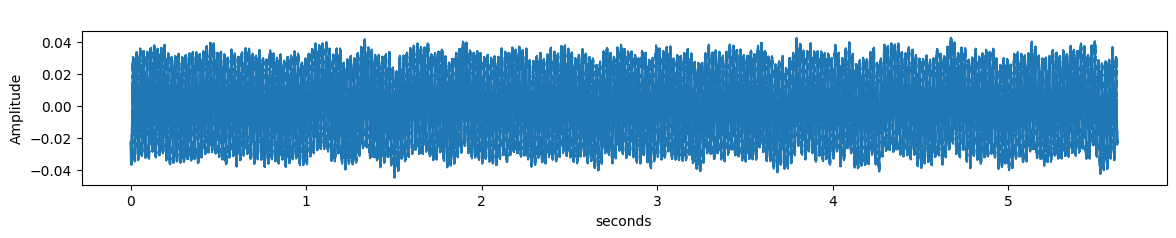

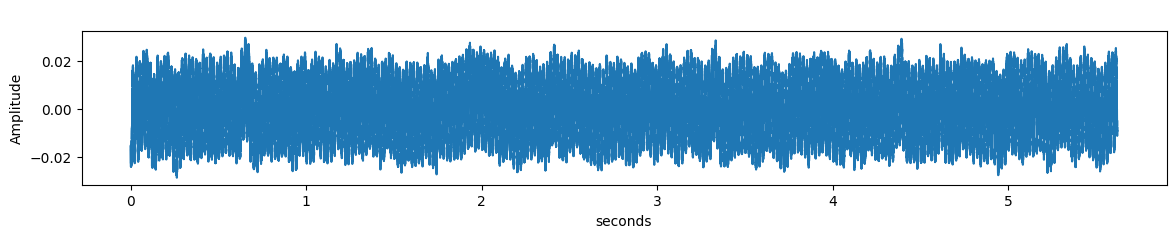

Output Sustain ADS1 vs ADS2 amb 8 Volts:


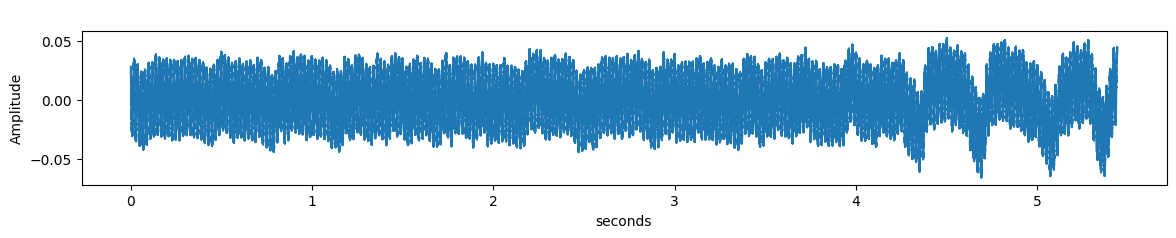

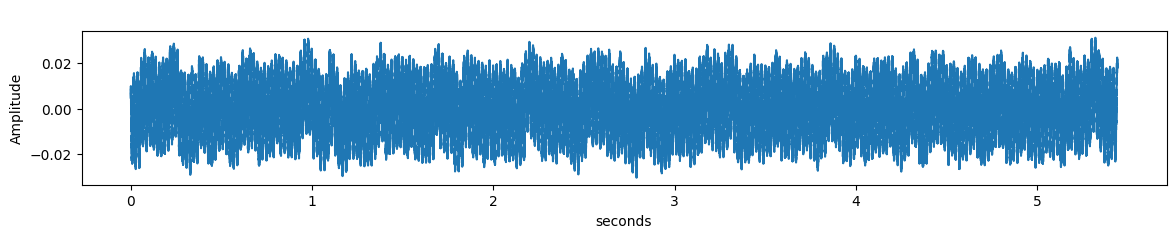

Output Sustain ADS1 vs ADS2 amb 9 Volts:


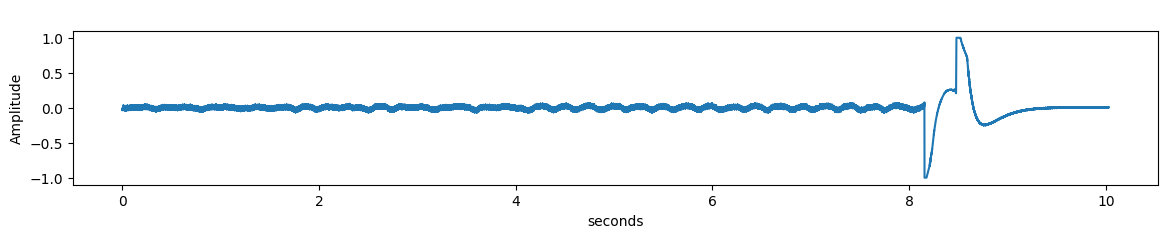

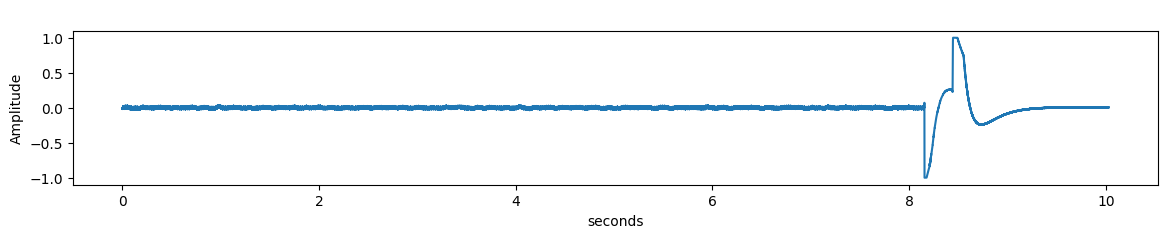

Output Sustain ADS1 vs ADS2 amb 10 Volts:


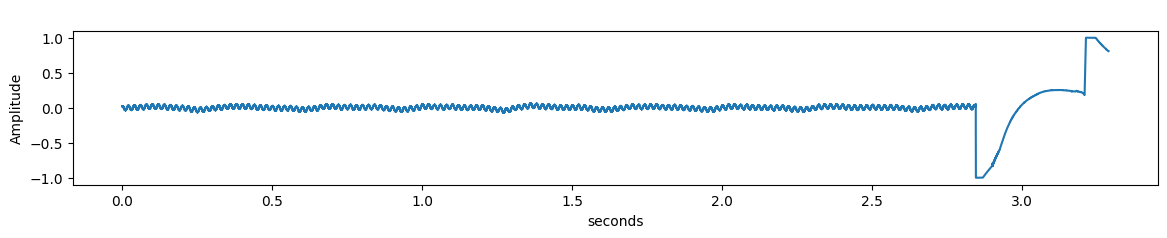

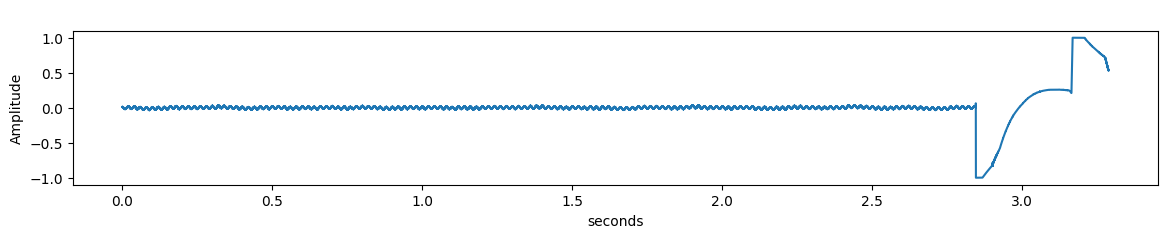

In [10]:
for i in range(len(sustain_list)):
  print('Output Sustain ADS1 vs ADS2 amb', i+1, 'Volts:')
  file = sustain_list[i]
  audio, sr = read_file(file)

  visualize(audio, sr)

# Sound vs ADS1 I
Per visualitzar amb claredat la relació entre el output del ADS1 i el so s'han enregistrat diferents mostres.

A continuació, d'un conunt de 5 enregistraments.

Output Sustain ADS1 vs ADS2 amb 1 Volts:


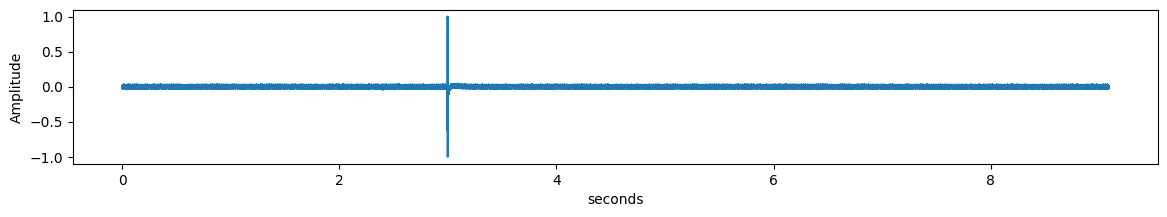

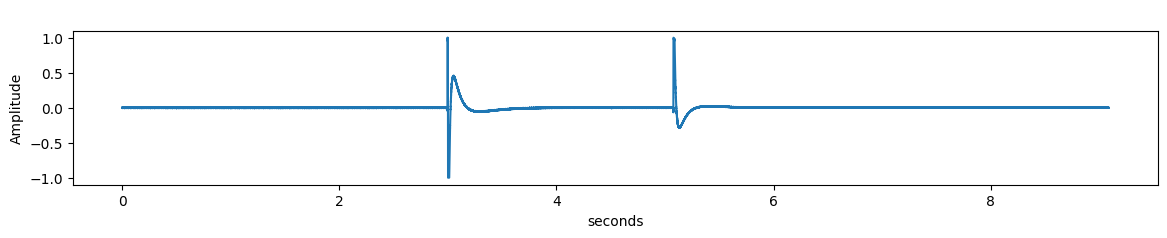

Output Sustain ADS1 vs ADS2 amb 2 Volts:


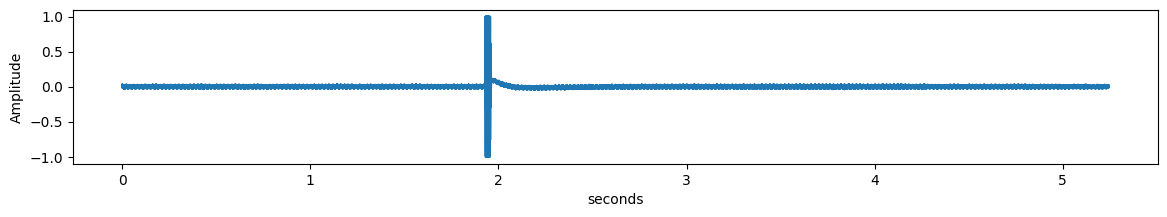

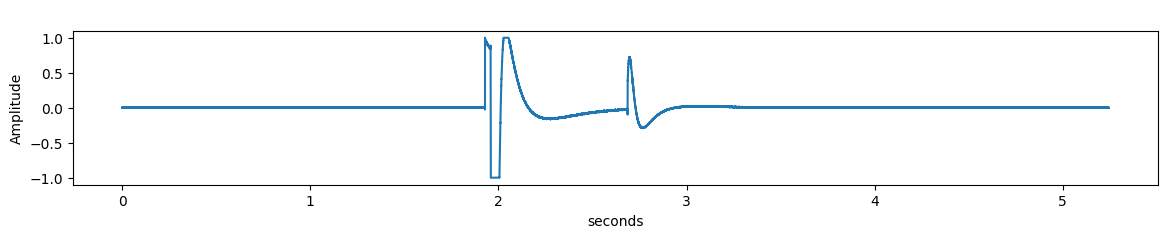

Output Sustain ADS1 vs ADS2 amb 3 Volts:


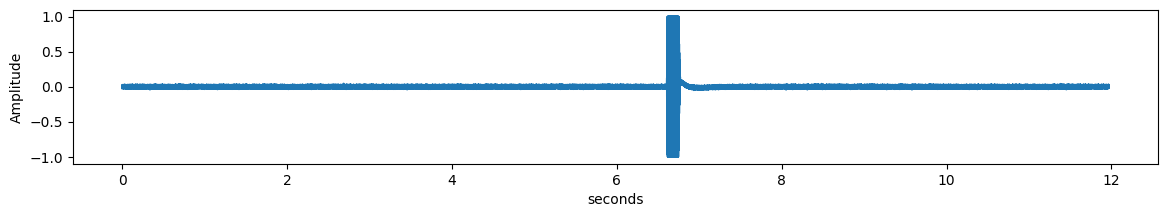

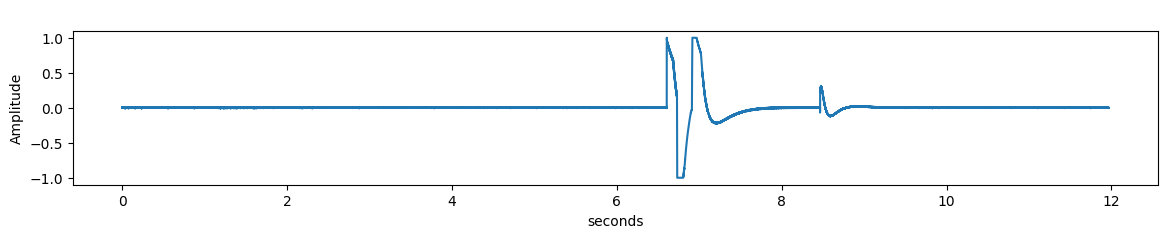

Output Sustain ADS1 vs ADS2 amb 4 Volts:


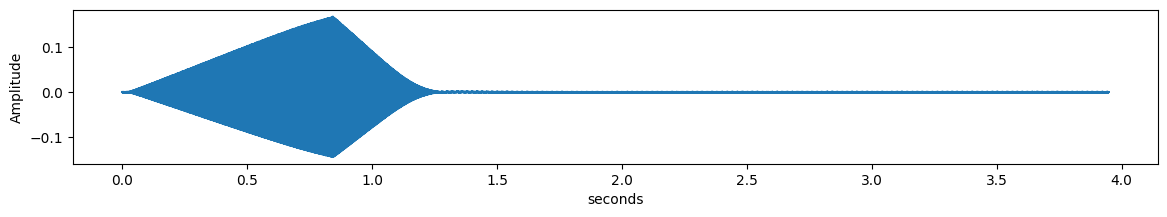

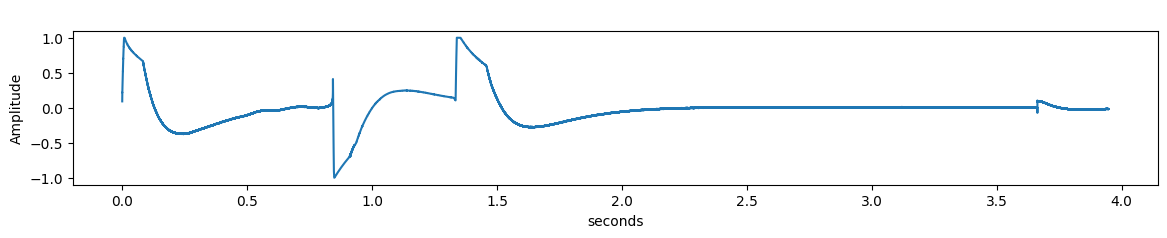

Output Sustain ADS1 vs ADS2 amb 5 Volts:


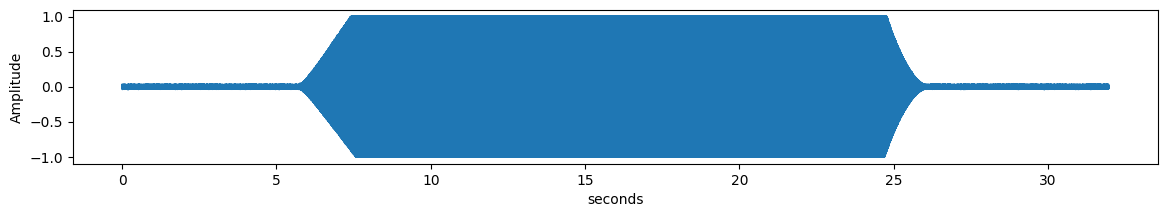

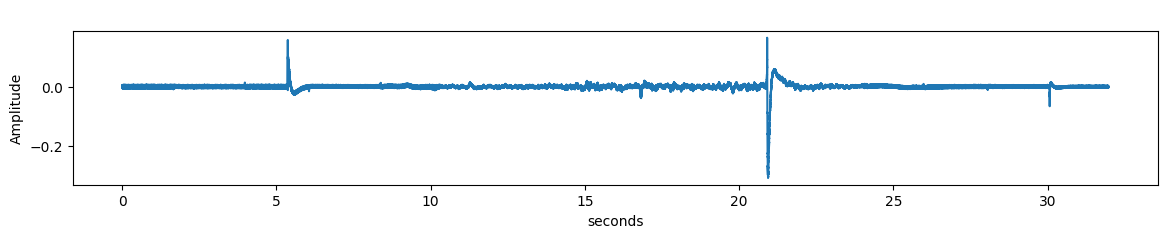

In [11]:
for i in range(len(ads1_sound)):
  print('Output Sustain ADS1 vs ADS2 amb', i+1, 'Volts:')
  file = ads1_sound[i]
  audio, sr = read_file(file)
  audio = stereo_audio_cutter(audio)

  visualize(audio, sr, title1 = '', title2 = ' ')

# Sound vs ADS1 II
Per visualitzar amb claredat la relació entre el output del ADS1 i el so s'han enregistrat diferents mostres.

A continuació, d'un conunt de 5 enregistraments.

Output Sound vs ADS1 


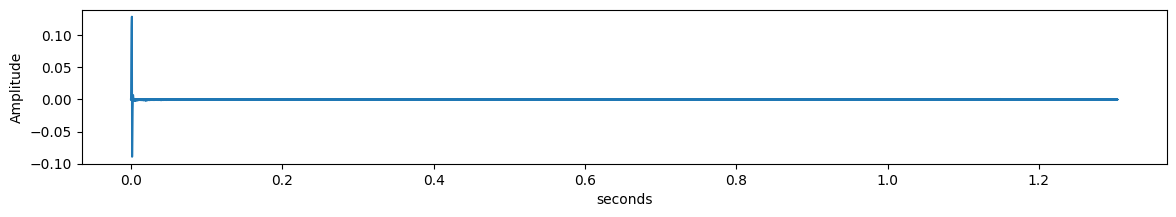

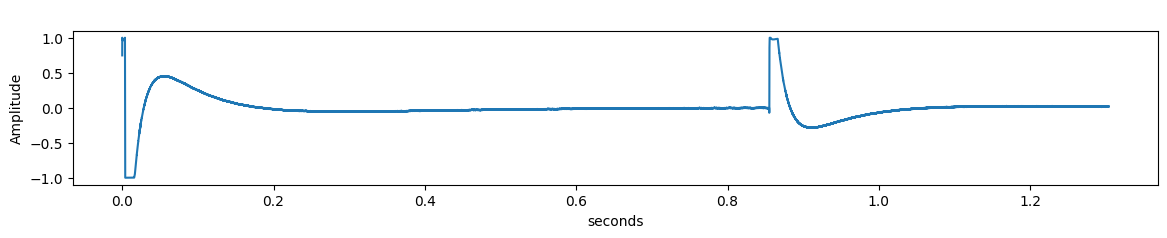

Output Sound vs ADS1 


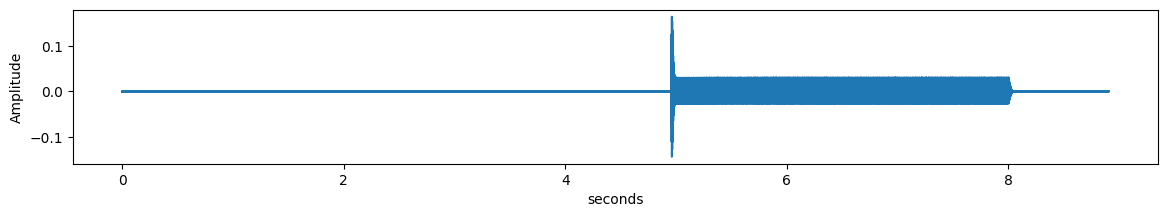

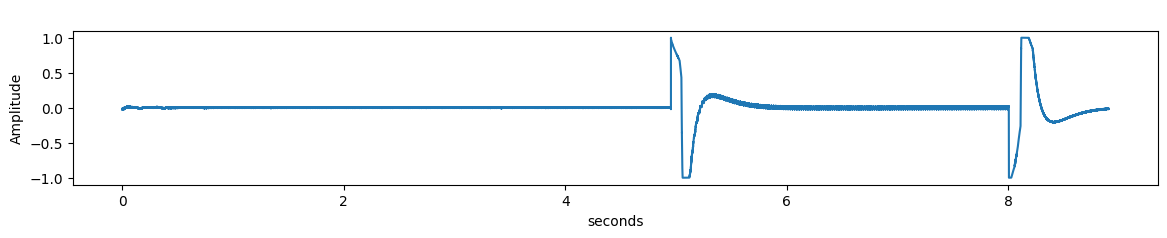

Output Sound vs ADS1 


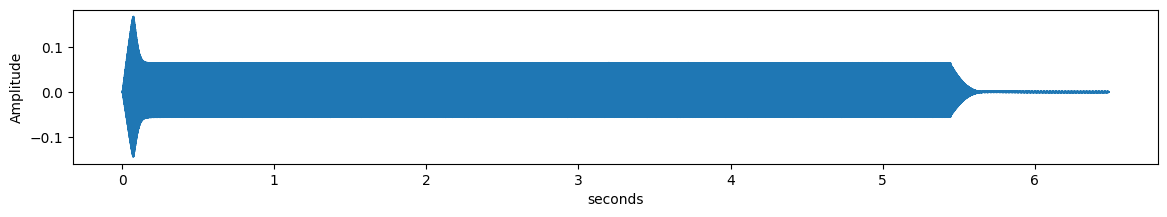

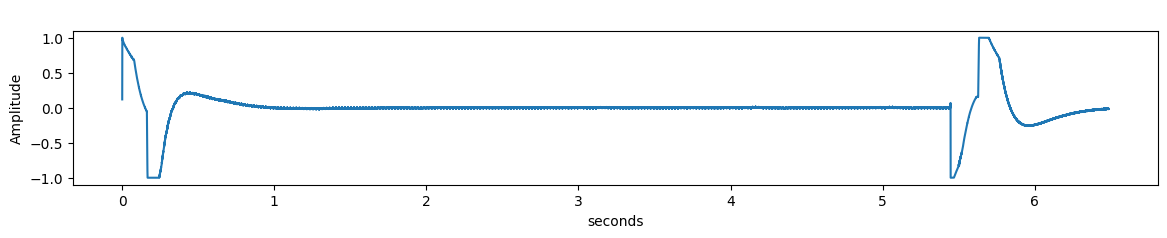

Output Sound vs ADS1 


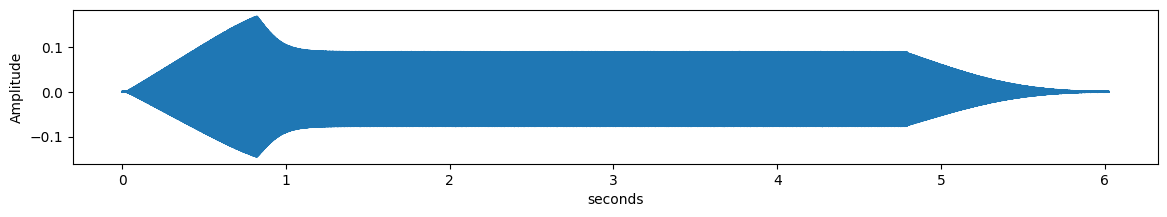

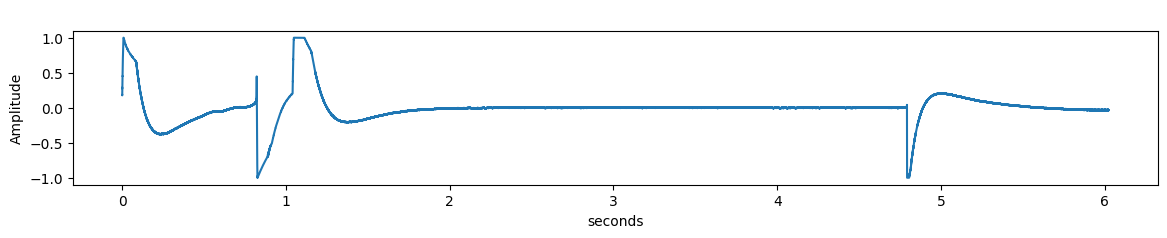

Output Sound vs ADS1 


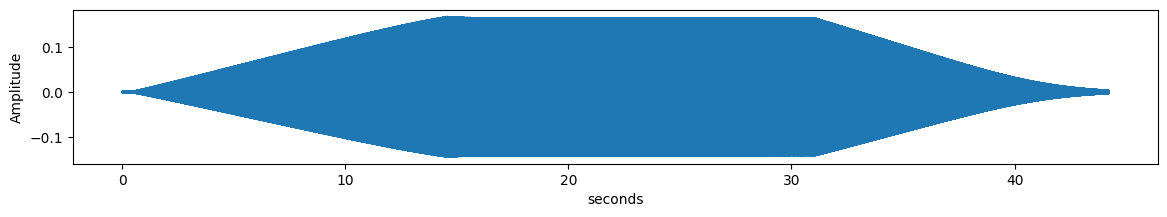

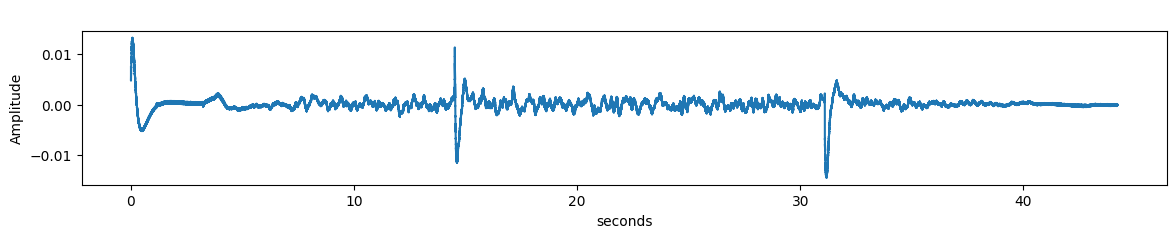

Output Sound vs ADS1 


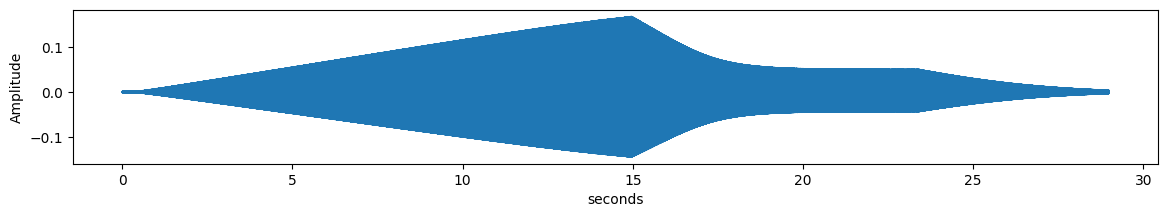

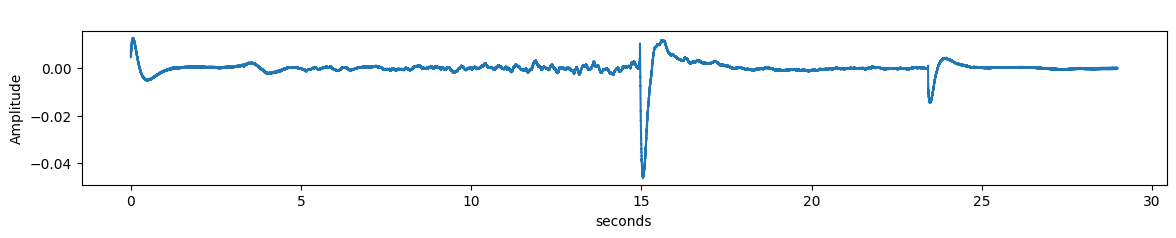

In [12]:
for i in range(len(ads1_full)):
  print('Output Sound vs ADS1 ')
  file = ads1_full[i]
  audio, sr = read_file(file)
  audio = stereo_audio_cutter(audio)

  visualize(audio, sr, title1 = '', title2 = ' ')